In [ ]:
from google.colab import drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    workspace = '/content/drive/MyDrive'
except:
    workspace = '.'
!pip install torch==1.7.0 torchvision==0.8.0 torchaudio==0.7.0
%pip install -U opencv-python
%pip install -U opencv-contrib-python

Mounted at /content/drive
     |████████████████████████████████| 776.7 MB 3.9 kB/s 
     |████████████████████████████████| 11.8 MB 40.7 MB/s 
     |████████████████████████████████| 7.6 MB 51.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which 

     |████████████████████████████████| 60.4 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 66.6 MB 193 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# **Image Classification 2: Machine Learning and Deep Learning**

Finally, we get to Deep Learning that everybody is waiting for. For a better understanding, let's start by building a linear classifier using the traditional linear classifier.

# **1. Trainditional Linear Classifier**

This can be done by using sklearn libaray. What we have to do is to set the classifier. For illustration purpose, we select some images from IMHere to build a binary classification problem.

Just like last tutorial, a file named label.csv including the image IDs and labels (the students who submitted the images) is still prepared for you. We randomly choose some samples of each catagory as the test sample.

Firstly, we still have to load the images and labels into the memory. 

ID filename label split
-- -------- ----- -----
0   1.jpg     1   train
1   2.jpg     0    val 
2   3.jpg     1   train
3   4.jpg     1   train
4   5.jpg     0   train
5   6.jpg     0   train
6   7.jpg     0    val 
7   8.jpg     0   train
8   9.jpg     1   train
9   10.jpg    1    val 
10  11.jpg    0    val 
11  12.jpg    1   train
12  13.jpg    1    val 
13  14.jpg    0   train


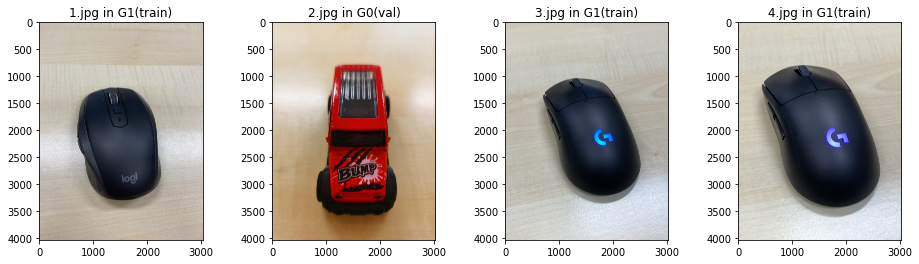

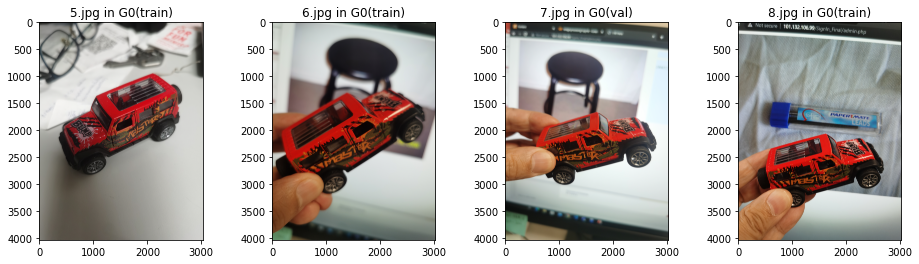

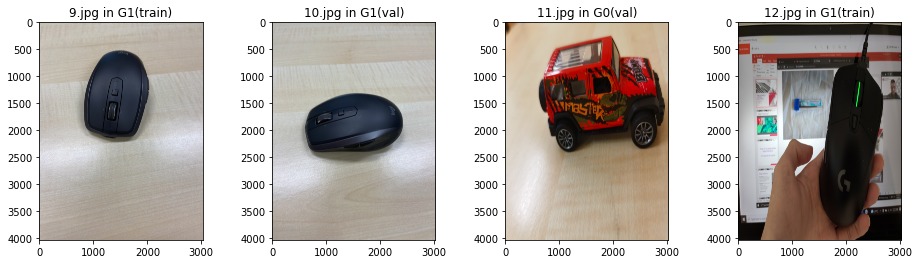

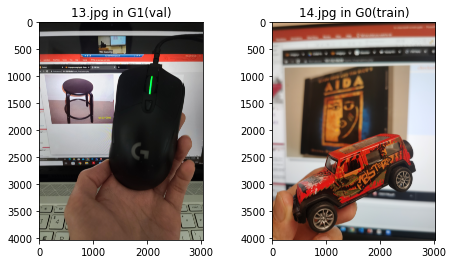

In [ ]:
# load the images
import os
import csv
import cv2
import numpy as np
from sklearn import datasets
from pprint import pprint
from collections import namedtuple
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

root = os.path.join(workspace, 'Tutorial-6/')
label_path = os.path.join(root, 'label.csv')

 
def labels2strs(labels: list) -> list:
    lengths = np.max([[len(j) for j in i] for i in labels], axis=0)
    format_str = ' '.join(['{:^%ds}'%length for length in lengths])
    seps = ' '.join(['-'*length for length in lengths])
    contents = [format_str.format(*row) for row in labels]
    contents.insert(1, seps)
    return contents

if os.path.exists(label_path):
    with open(label_path) as f:
        flabels = list(csv.reader(f))
    print(*labels2strs(flabels), sep='\n')
else:
    raise ValueError('Invalid label file path [%s]'%label_path)


samples = {'train': [], 'val': []}

class Sample:
    def __init__(self, idx=0, fname='', img=None, feat=None, label=None):
        self.idx = idx
        self.fname = fname
        self.img = img
        self.feat = feat
        self.label = label
        self.pred = None

for idx, fname, label, split in flabels[1:]:
    idx, label = int(idx), int(label)
    if idx % 4 == 0:
        plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, idx%4+1)
    plt.title(f'{fname} in G{label}({split})')

    fpath = os.path.join(root, fname)
    if not os.path.isfile(fpath):
        raise ValueError('%s not found' % fpath)
    else:
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]
        if idx == 0:
          H, W, C = img.shape
        else:
          img = cv2.resize(img, (W, H))
        
        plt.imshow(img)
        
        samples[split].append(Sample(idx, fname, img, None, label))

After that, we need to extract the features.

In [ ]:
## extract features

def get_feat(img):
#      return hog(img)
#      return sift_feat(img)
      return gray_histogram(img)
#      return color_histogram(img)

def calc_distance(x, y):
    return L2_distance(x, y)

def gray_histogram(img: np.array, norm: bool = True) -> np.array:
    if img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = np.array([len(img[img == i]) for i in range(256)])
    if norm:
        return hist / np.size(img)
    return hist

def color_histogram(img : np.array, norm : bool = True) -> np.array:
    return np.concatenate([gray_histogram(img[..., i], norm=norm) for i in range(3)])


def L2_distance(x, y):
    return ((x - y) ** 2).sum() ** 0.5

def L2_distance_sift(x, y):
    dist = ((x[:, None] - y[None, :])**2).sum(axis=-1).min(axis=-1)
    dist.sort()
    return dist[:15].mean()


for sample in samples['train']:
    sample.feat = get_feat(sample.img)

for sample in samples['val']:
    sample.feat = get_feat(sample.img)

All of above operations are same with last tutorial. Then we need to call the traditional classifier for training and predition.

In [ ]:
# use traditional classifier
train_samples = [sample.feat for sample in samples['train']]
train_labels = [sample.label for sample in samples['train']]

classifier = make_pipeline(StandardScaler(), SGDClassifier(max_iter=50000, tol=1e-3, learning_rate='constant', eta0=0.1, loss='log'))

# call classifier for training
classifier.fit(train_samples, train_labels)

test_samples = [sample.feat for sample in samples['val']]
test_labels = [sample.label for sample in samples['val']]

# call classifier for prediction
results = classifier.predict(test_samples)

# display the results
for sample, result in zip(samples['val'], results):
    sample.pred = result
    print(sample.fname, 'with label', sample.label, 'is predicted as', sample.pred)

2.jpg with label 0 is predicted as 0
7.jpg with label 0 is predicted as 0
10.jpg with label 1 is predicted as 1
11.jpg with label 0 is predicted as 1
13.jpg with label 1 is predicted as 1


Not bad. Now we can implement the classifer with a simple neural network.

# **2. A Simple Nearual Network**

We build a network with 2 layers. The 1st layer is with X neurona for taking the feature vectors we extract previously. This is the reason that there are X neurons to be adapt to the dimensionality of the feature vectors. The 2nd layer is with 1 node as the output which is connected to the neurons in the 1st layers through edges with weights. Now, let's pick the same gradient decent alogorithm for learning. 

In [ ]:
from torch.functional import Tensor
from skimage import feature
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

input_size = len(train_samples[0])
output_size = 1
learning_rate = 1

# build the 2-layer NN
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = self.sigmoid(y_pred)
        return y_pred

x_train = torch.tensor(train_samples).to(torch.float32)
y_train = torch.tensor(train_labels).reshape(-1, 1).to(torch.float32)
x_test = torch.tensor(test_samples).to(torch.float32)

model = SimpleNN()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# training
model.train()
num_epochs = 50000
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        inputs = Variable(x_train).cuda()
        target = Variable(y_train).cuda()
    else:
        inputs = Variable(x_train)
        target = Variable(y_train)
 
    # forward
    out = model(inputs)

    # calculate loss
    loss = criterion(out, target)

    # zero gradient
    optimizer.zero_grad()

    # backward propagation
    loss.backward()

     # Updating parameters
    optimizer.step()
 
    if (epoch+1) % 1000 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))

# testing
model.eval()
results = model(Variable(x_test))

# display the results
for sample, result in zip(samples['val'], results):
    sample.pred = 1 if result > 0.5 else 0
    print(sample.fname, 'with label', sample.label, 'is predicted as', sample.pred)

Epoch[1000/50000], loss: 0.521387
Epoch[2000/50000], loss: 0.430630
Epoch[3000/50000], loss: 0.373697
Epoch[4000/50000], loss: 0.333747
Epoch[5000/50000], loss: 0.303398
Epoch[6000/50000], loss: 0.279058
Epoch[7000/50000], loss: 0.258797
Epoch[8000/50000], loss: 0.241492
Epoch[9000/50000], loss: 0.226436
Epoch[10000/50000], loss: 0.213158
Epoch[11000/50000], loss: 0.201326
Epoch[12000/50000], loss: 0.190698
Epoch[13000/50000], loss: 0.181089
Epoch[14000/50000], loss: 0.172353
Epoch[15000/50000], loss: 0.164376
Epoch[16000/50000], loss: 0.157061
Epoch[17000/50000], loss: 0.150331
Epoch[18000/50000], loss: 0.144118
Epoch[19000/50000], loss: 0.138368
Epoch[20000/50000], loss: 0.133030
Epoch[21000/50000], loss: 0.128064
Epoch[22000/50000], loss: 0.123434
Epoch[23000/50000], loss: 0.119106
Epoch[24000/50000], loss: 0.115055
Epoch[25000/50000], loss: 0.111254
Epoch[26000/50000], loss: 0.107683
Epoch[27000/50000], loss: 0.104321
Epoch[28000/50000], loss: 0.101152
Epoch[29000/50000], loss: 0.0

It's not suprising that the results are similar with that of the traditional linear classifiers. Because these two forms of classifiers are theoritically the same.


Would stacking more layers help?

In [ ]:
# see if a 3-layer NN helps
# display the results
class SimpleNN_3layer(nn.Module):
    def __init__(self):
        super(SimpleNN_3layer, self).__init__()
        ?

    def forward(self, x):
        y_pred = ?
        return y_pred

model = SimpleNN_3layer()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# training and testing
model.train()
num_epochs = 50000
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        inputs = Variable(x_train).cuda()
        target = Variable(y_train).cuda()
    else:
        inputs = Variable(x_train)
        target = Variable(y_train)
 
    # forward
    out = model(inputs)
    loss = criterion(out, target)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    if (epoch+1) % 1000 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))

model.eval()
results = model(Variable(x_test))

# display the results
for sample, result in zip(samples['val'], results):
    sample.pred = 1 if result > 0.5 else 0
    print(sample.fname, 'with label', sample.label, 'is predicted as', sample.pred)

Epoch[1000/50000], loss: 0.235635
Epoch[2000/50000], loss: 0.005977
Epoch[3000/50000], loss: 0.002408
Epoch[4000/50000], loss: 0.001457
Epoch[5000/50000], loss: 0.001029
Epoch[6000/50000], loss: 0.000790
Epoch[7000/50000], loss: 0.000637
Epoch[8000/50000], loss: 0.000533
Epoch[9000/50000], loss: 0.000456
Epoch[10000/50000], loss: 0.000398
Epoch[11000/50000], loss: 0.000353
Epoch[12000/50000], loss: 0.000317
Epoch[13000/50000], loss: 0.000287
Epoch[14000/50000], loss: 0.000262
Epoch[15000/50000], loss: 0.000241
Epoch[16000/50000], loss: 0.000223
Epoch[17000/50000], loss: 0.000207
Epoch[18000/50000], loss: 0.000193
Epoch[19000/50000], loss: 0.000181
Epoch[20000/50000], loss: 0.000170
Epoch[21000/50000], loss: 0.000161
Epoch[22000/50000], loss: 0.000152
Epoch[23000/50000], loss: 0.000145
Epoch[24000/50000], loss: 0.000138
Epoch[25000/50000], loss: 0.000131
Epoch[26000/50000], loss: 0.000125
Epoch[27000/50000], loss: 0.000120
Epoch[28000/50000], loss: 0.000115
Epoch[29000/50000], loss: 0.0

It may help because, by stacking more layers, we create a more complex model. However, it may not, because the more complex the model is, the more data is in need (the fit the model).

However, this simple network has already included almost everything you need about the neural networks. To build deep networks for learning can be simply stacking much more layers.

# **3. Deep Neural Netorks**

We can stack more layers by simply adding more to the pipline. However, we don't have enough data from IMHere for traning when more layers are stacked. Therefore, let's use a pretrain ResNet to address this issue.

This time we don't have to extract the features. Deep neural networks usually take the images as the input directly.

In [ ]:
# load pre-trained ResNet for fature extraction
# add a few FC for traning (fix the weights of ResNet)
# test and display the results
import os
import time
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.models as models
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

inference_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

def img_transform(img_rgb, transform=None):
    """
    transform images
    :param img_rgb: PIL Image
    :param transform: torchvision.transform
    :return: tensor
    """

    if transform is None:
        raise ValueError("there is no transform")

    img_t = transform(Image.fromarray(img_rgb))
    return img_t

# load data
train_imgs = [img_transform(sample.img, inference_transform) for sample in samples['train']]
train_imgs = torch.stack(train_imgs, dim=0)
test_imgs = [img_transform(sample.img, inference_transform) for sample in samples['val']]
test_imgs = torch.stack(test_imgs, dim=0)

# define a classifier following the network
class classification_head(nn.Module):
	def __init__(self,in_ch,num_classes):
		super(classification_head,self).__init__()
		self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
		self.fc = nn.Linear(in_ch,num_classes)

	def forward(self, x):
		x = self.avgpool(x)
		x = torch.flatten(x, 1)
		x = self.fc(x)
		return x

#define ResNet model
class Net(nn.Module):
	def __init__(self, input_ch, num_class,pretrained=True):
		super(Net,self).__init__()
		model = models.resnet50(pretrained=pretrained)
		self.backbone =  nn.Sequential(*list(model.children())[:-2]) #remove the last Avgpool and Fully Connected Layer
		self.classification_head = classification_head(2048, num_class)
										
	def forward(self,x):
		x = self.backbone(x)
		output = self.classification_head(x)
		return output

# creat a model
model = Net(3, 1)
# fix the weights of ResNet
for p in model.backbone.parameters():
  p.requires_grad = False

model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.train()

# training
num_epochs = 200
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        inputs = Variable(train_imgs).cuda()
        target = Variable(y_train).cuda()
    else:
        inputs = Variable(train_imgs)
        target = Variable(y_train)
 
    # forward
    out = model(inputs)
    loss = criterion(out, target)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))

Epoch[20/200], loss: 0.033857
Epoch[40/200], loss: 0.004742
Epoch[60/200], loss: 0.000964
Epoch[80/200], loss: 0.000259
Epoch[100/200], loss: 0.000090
Epoch[120/200], loss: 0.000039
Epoch[140/200], loss: 0.000020
Epoch[160/200], loss: 0.000012
Epoch[180/200], loss: 0.000007
Epoch[200/200], loss: 0.000005


In [ ]:
#testing
model.eval()
results = model(Variable(test_imgs))

# display the results
for sample, result in zip(samples['val'], results):
    sample.pred = 1 if result > 0.5 else 0
    print(sample.fname, 'with label', sample.label, 'is predicted as', sample.pred)

2.jpg with label 0 is predicted as 0
7.jpg with label 0 is predicted as 0
10.jpg with label 1 is predicted as 1
11.jpg with label 0 is predicted as 0
13.jpg with label 1 is predicted as 1


It seems work well.